### TensorFlow Classification

In [47]:
import tensorflow as tf

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import describe

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Binary or Multinomial Classification 

In [220]:
is_binary = False

if is_binary:
    x, y = make_classification(n_samples=1000, n_features=5, n_informative=2, 
                               class_sep=1, random_state=1)
else:
    classes = 4
    x, y = make_classification(n_samples=1000, random_state=1, n_features=6, 
                               n_classes=classes, n_informative=3, class_sep=2)
y = y.reshape(-1,1)

In [221]:
fstring = f"| X Shape: {x.shape}\n| Y Shape: {y.shape}"
dashes = '+'+'-'*int(len(fstring)/2) + '+'
print(f"{dashes}\n{fstring}\n{dashes}")

+--------------------+
| X Shape: (1000, 6)
| Y Shape: (1000, 1)
+--------------------+


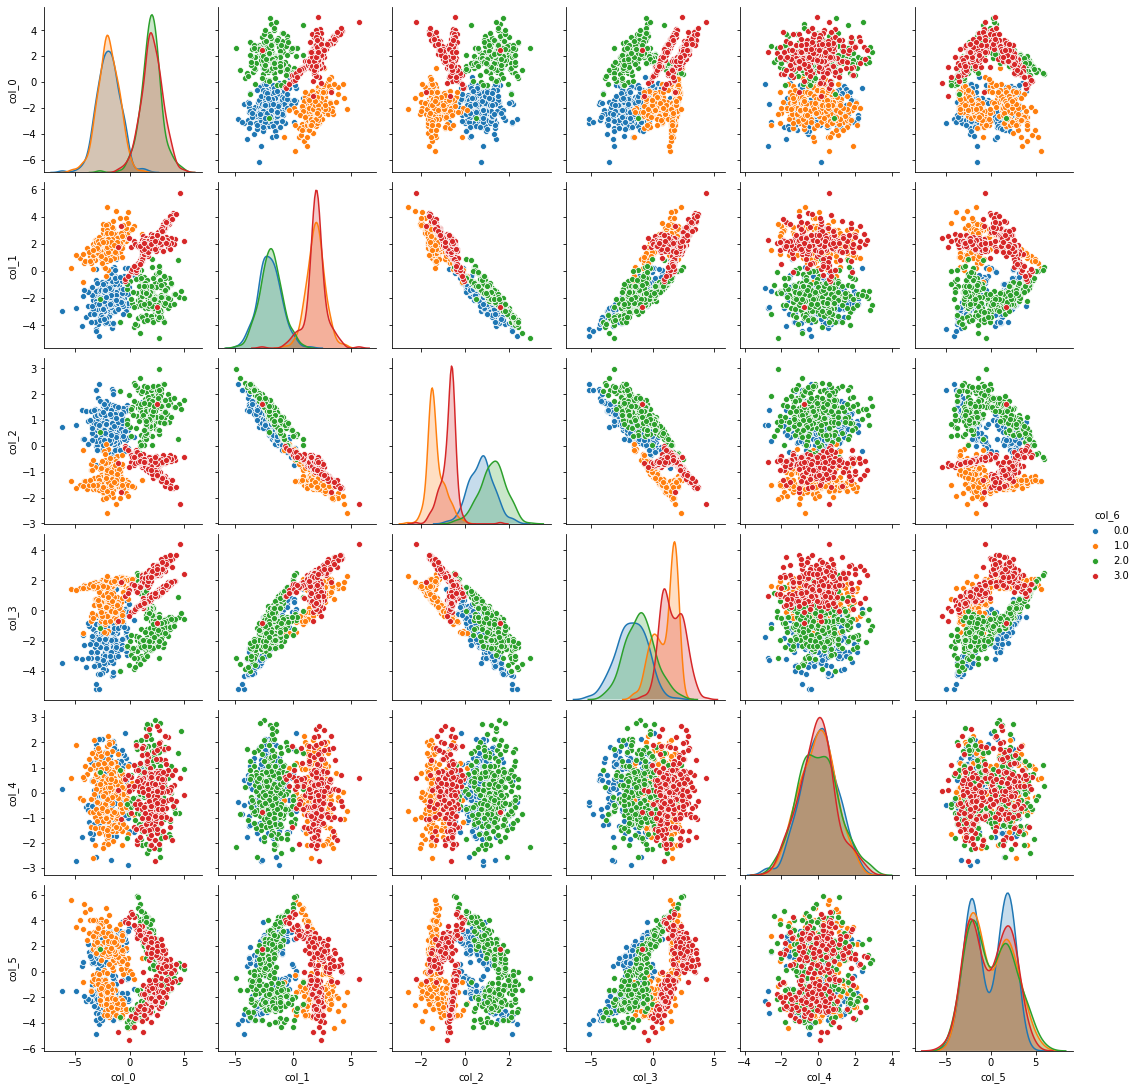

In [222]:
df_pd = pd.DataFrame(np.append(x,y, axis=1))
df_pd.columns = [f'col_{i}' for i in df_pd.columns]
sns.pairplot(df_pd, hue=df_pd.columns[-1])

One hot encode Y

In [223]:
y = OneHotEncoder(sparse=False).fit_transform(y)

In [224]:
y

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

Split Train and Test

In [225]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [226]:
train_x, train_y = train_x.reshape((-1,train_x.shape[1])), train_y.reshape((-1,train_y.shape[1]))

new_fstring = f"| New X Shape: {train_x.shape}\n| New Y Shape: {train_y.shape}"
dashes = '+'+'-'*int(len(new_fstring)/2) + '+'
print(f"{dashes}\n{new_fstring}\n{dashes}")

+-----------------------+
| New X Shape: (800, 6)
| New Y Shape: (800, 4)
+-----------------------+


Model Parameters

In [227]:
learn_rate = 0.01
batch = 100
epochs = 150

Initialize Variable Inputs 

In [228]:
x_ph = tf.placeholder(tf.float32, [None, train_x.shape[1]], name='X')
y_ph = tf.placeholder(tf.float32, [None, train_y.shape[1]], name='Y')

Set Model Weights and Bias

In [229]:
W = tf.Variable(tf.random_normal([train_x.shape[1], train_y.shape[1]], stddev=.05), name='Weights')
# W = tf.Variable(tf.zeros([train_x.shape[1], 1]), name='Weights')
b = tf.Variable(tf.zeros([train_y.shape[1]]), name='Bias')

Predictions

In [230]:
logits = tf.nn.sigmoid(tf.add(tf.matmul(x_ph, W), b))

Define Loss Function

In [231]:
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_ph))

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_ph))

Define Accuracy Function

In [232]:
pred = tf.round(tf.sigmoid(logits))

correct = tf.cast(tf.equal(pred, y_ph), dtype=tf.float32)

acc = tf.reduce_mean(correct)

Define Optimizer 

In [233]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learn_rate).minimize(cost)

In [234]:
init = tf.global_variables_initializer()

Batch Train Model

In [235]:
with tf.Session() as sess:
    sess.run(init)
    n_batches = int(train_x.shape[0]/batch)
    loss_trace = []
    acc_trace = []
    for i in range(epochs):
        for _ in range(n_batches):
            batch_idx = np.random.choice(len(train_x), size=batch)
            batch_X = train_x[batch_idx]
            batch_Y = train_y[batch_idx]
            _, tmp_loss, tmp_acc = sess.run([optimizer, cost, acc],
                                             feed_dict={x_ph: batch_X, y_ph:batch_Y})
            loss_trace.append(tmp_loss)
            acc_trace.append(tmp_acc)
        if i % 10 == 0 or i == 0:  
            print("Epoch: {} | Loss: {:04f} | Training Accuracy: {:2f}".format(i, tmp_loss, tmp_acc))
                
    pred_y = sess.run(logits, feed_dict={x_ph: test_x})


Epoch: 0 | Loss: 0.842791 | Training Accuracy: 0.250000
Epoch: 10 | Loss: 0.830911 | Training Accuracy: 0.250000
Epoch: 20 | Loss: 0.824428 | Training Accuracy: 0.250000
Epoch: 30 | Loss: 0.817461 | Training Accuracy: 0.250000
Epoch: 40 | Loss: 0.808848 | Training Accuracy: 0.250000
Epoch: 50 | Loss: 0.805488 | Training Accuracy: 0.250000
Epoch: 60 | Loss: 0.794505 | Training Accuracy: 0.250000
Epoch: 70 | Loss: 0.786352 | Training Accuracy: 0.250000
Epoch: 80 | Loss: 0.785800 | Training Accuracy: 0.250000
Epoch: 90 | Loss: 0.778745 | Training Accuracy: 0.250000
Epoch: 100 | Loss: 0.777507 | Training Accuracy: 0.250000
Epoch: 110 | Loss: 0.775730 | Training Accuracy: 0.250000
Epoch: 120 | Loss: 0.771957 | Training Accuracy: 0.250000
Epoch: 130 | Loss: 0.767072 | Training Accuracy: 0.250000
Epoch: 140 | Loss: 0.763891 | Training Accuracy: 0.250000


Not sure why training accuracy is so bad ... 

Implementing feature selection via L1 regularization or RandomForest may prove better results

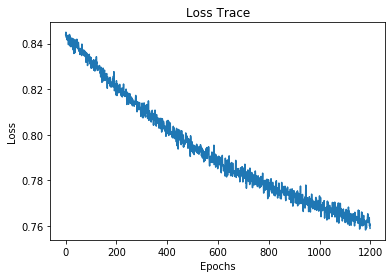

In [236]:
plt.plot(loss_trace)
plt.title('Loss Trace')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [237]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, roc_curve

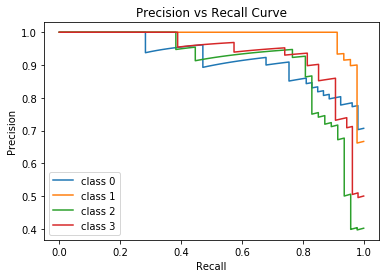

In [238]:
precision, recall = {}, {}
for i in range(test_y.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(test_y[:,i],
                                                        pred_y[:,i])
    plt.plot(recall[i], precision[i], label=f'class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision vs Recall Curve')
plt.show()

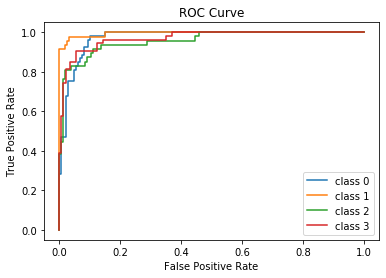

In [239]:
fpr, tpr = {}, {}
for i in range(test_y.shape[1]):
    fpr[i], tpr[i],_ = roc_curve(y_true=test_y[:, i], y_score=pred_y[:, i])
    plt.plot(fpr[i], tpr[i], label=f'class {i}')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


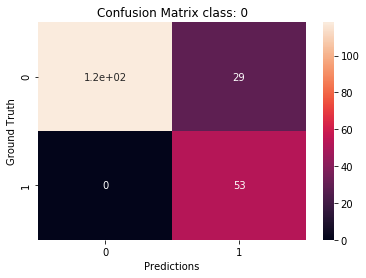

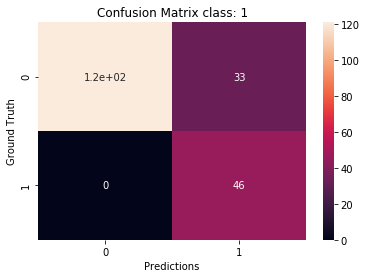

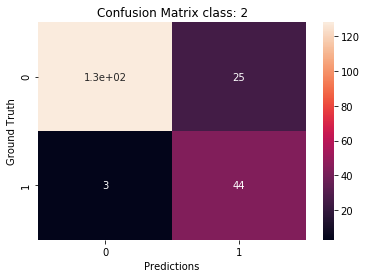

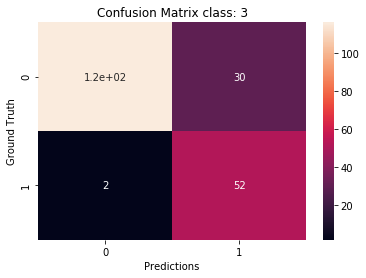

In [240]:
cm = multilabel_confusion_matrix(y_true=test_y, y_pred=np.round(pred_y))
for i in range(test_y.shape[1]):
    sns.heatmap(cm[i], annot=True)
    plt.title(f'Confusion Matrix class: {i}')
    plt.xlabel('Predictions')
    plt.ylabel('Ground Truth')
    plt.show()